# Reading metadata of an rpx file

In [123]:
%%bash
cd ../example_data
in_rxp=T121_wytham_winter.rxp

source activate lidar #activate anaconda lidar env
pylidar_info --input $in_rxp

Driver Name: riegl

FNAME T121_wytham_winter.rxp
HEADER
  BEAM_DIVERGENCE 0.0003000000142492354
  BEAM_EXIT_DIAMETER 0.007000000216066837
  BUILD wfm
  GROUP_VELOCITY 299709344.0
  HEIGHT 191.68824768066406
  HMSL 144.55908203125
  LATITUDE 51.77595518621673
  LONGITUDE -1.3375550383074863
  NUMBER_OF_PULSES 22438191
  NUM_FACETS 3
  PHI_INC 0.03999999910593033
  PHI_MAX 360.0
  PHI_MIN 0.0
  PITCH -0.00722059277327496
  ROLL -0.01824368752255979
  ROTATION_MATRIX [[ 0.2835843  -0.95874819 -0.01954107  0.        ]
 [ 0.95892013  0.28367081 -0.00174947  0.        ]
 [ 0.00722053 -0.0182422   0.99980752  0.        ]
 [ 0.          0.          0.          1.        ]]
  SCANLINE_IDX_MAX 2501
  SCANLINE_IDX_MIN 0
  SCANLINE_MAX 8979
  SCANLINE_MIN 0
  SERIAL S9999808
  THETA_INC 0.03999999910593033
  THETA_MAX 130.0
  THETA_MIN 30.0
  TYPE_ID VZ-400
  UNAMBIGUOUS_RANGE 10000.0
  YAW 1.2832588186406764


# Canopy profiles: upright scan only > PAVD profile

The conversion of a single upright scan to a PAVD profile can be done directly from an rxp file. The PAIe around the hinge region will be used to generate the profile's total PAIe. The PAVD profile is limited to the zenith angles from the upright scan (and generally has an upper limit of 30 deg). The scan will be levelled using the pitch, roll, yaw information stored in the rxp metadata.

In [117]:
%%bash
cd ../example_data
in_rxp=T121_wytham_winter.rxp #set variables
vpf=$(echo `basename $in_rxp | cut -d'.' -f1`.csv)
plane_report=$(echo `basename $in_rxp | cut -d'.' -f1`.rpt)
zen_min=35.0
zen_max=70.0

source activate lidar #activate anaconda lidar env
pylidar_canopy -i $in_rxp -o $vpf -w -p -r $plane_report --minzenith $zen_min --maxzenith $zen_max

echo "========================================"

# let's also make a profile without correcting for terrain to illustrate the differences
vpf_nocor=$(echo `basename $in_rxp | cut -d'.' -f1`_nocor.csv)
pylidar_canopy -i $in_rxp -o $vpf_nocor -w --minzenith $zen_min --maxzenith $zen_max #not terrain corrected

Applying plane correction to point heights...
.wfm file not found. Use "rxp2wfm -i" to extract first.

Calculating vertical plant profiles...
.wfm file not found. Use "rxp2wfm -i" to extract first.

Calculating vertical plant profiles...
.wfm file not found. Use "rxp2wfm -i" to extract first.



Option -w will use the weighted multiple returns. Not using this flag will use first returns only [CHECK WITH JOHN].

Option -p will do a plane correction of the data (see Calders et. al, 2014); with a report being generated if option -r is used as well.

We can now extract the effective Plant Area Index, PAIe (i.e. the integral of the PAVD profile) and plot the PAVD profile.

Analysing height corrected profile ../example_data/T121_wytham_winter.csv 

PAIe (hinge region) is 1.54
PAI (linear) is 1.45


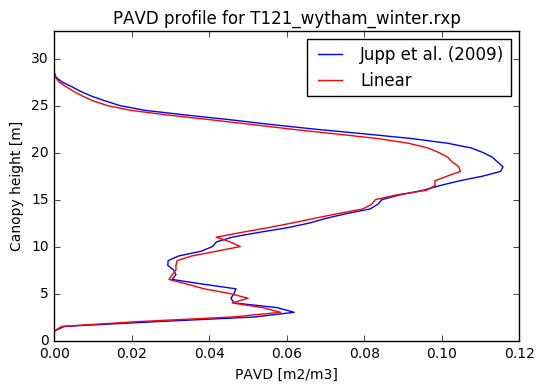

Comparing height corrected vs. uncorrected VPFs:
Height corrected: PAIe (hinge region) is 1.54
Uncorrected height PAIe (hinge region) is 1.54


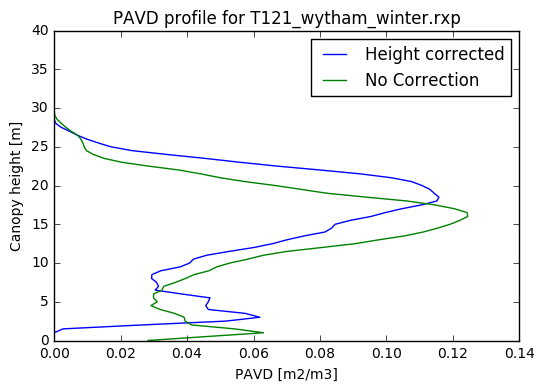

In [10]:
import csv
import numpy as np
import matplotlib.pyplot as plt

path="../example_data/"
in_rxp="T121_wytham_winter.rxp"
vpf=path+in_rxp.split('.')[0]+".csv"

print("Analysing height corrected profile %s \n" %vpf)

reader=csv.reader(open(vpf), delimiter=",")
firstLine=True
height=PAIe=PAVD=lin_PAI=lin_PAVD=np.array([])
for row in reader:
    if firstLine:
        headers=row
#         print(row[-5])
        firstLine=False
    else:
        height=np.append(height,float(row[0]))
        PAIe=np.append(PAIe,float(row[-2]))
        PAVD=np.append(PAVD,float(row[-1]))
        lin_PAI=np.append(lin_PAI,float(row[-5]))
        lin_PAVD=np.append(lin_PAVD,float(row[-4]))
        
# print(height)
print("PAIe (hinge region) is %.2f" % max(PAIe))
print("PAI (linear) is %.2f" % max(lin_PAI))

plt.plot(PAVD,height, label="Jupp et al. (2009)",color='b')
plt.plot(lin_PAVD,height, label="Linear", color='r')
plt.xlabel('PAVD [m2/m3]')
plt.ylabel('Canopy height [m]')
plt.title('PAVD profile for %s' % in_rxp)
plt.ylim(0,33)
plt.legend()
plt.show()

print("============================================================================")
####### THE FOLLOWING SECTION WILL COMPARE THE HEIGHT CORRECTED PAVD PROFILE (JUPP METHOD) VS. UNCORRECTED HEIGHT #####

print("Comparing height corrected vs. uncorrected VPFs:")

vpf_nocor=path+in_rxp.split('.')[0]+"_nocor.csv"
reader=csv.reader(open(vpf_nocor), delimiter=",")
firstLine=True
PAVD_nocor=PAIe_nocor=np.array([])
for row in reader:
    if firstLine:
        firstLine=False
    else:
        PAVD_nocor=np.append(PAVD_nocor,float(row[-1]))
        PAIe_nocor=np.append(PAIe_nocor,float(row[-2]))
        
print("Height corrected: PAIe (hinge region) is %.2f" % max(PAIe))
print("Uncorrected height PAIe (hinge region) is %.2f" % max(PAIe_nocor))

plt.plot(PAVD,height, label="Height corrected",color='b')
plt.plot(PAVD_nocor,height, label="No Correction", color='g')
plt.xlabel('PAVD [m2/m3]')
plt.ylabel('Canopy height [m]')
plt.title('PAVD profile for %s' % in_rxp)
plt.ylim(0,40)
plt.legend()
plt.show()

# Canopy profiles: combining upright and tilted scan

First we need to convert the individual scans to spd; then we need to generate the profile:

In [43]:
%%bash
cd ../example_data
in_rxp=T121_wytham_winter.rxp #set variables
spd_out=$(echo `basename $in_rxp | cut -d'.' -f1`.spd)
sop=$(echo `basename $in_rxp | cut -d'_' -f1`.DAT)

in_rxp_tilt=T122_wytham_winter.rxp #set variables
spd_out_tilt=$(echo `basename $in_rxp_tilt | cut -d'.' -f1`.spd)
sop_tilt=$(echo `basename $in_rxp_tilt | cut -d'_' -f1`.DAT)

vpf=$(echo `basename $in_rxp | cut -d'.' -f1`_comb.csv)
plane_report=$(echo `basename $in_rxp | cut -d'.' -f1`_comb.rpt)

source activate lidar #activate anaconda lidar env

### CONVERSION TO SPD:
# pylidar_translate -i $in_rxp -o $spd_out -f SPDV4 --externalrotationfn $sop --scaling POINT X UINT32 1000 -1000 --scaling POINT Y UINT32 1000 -1000 --scaling POINT Z UINT32 1000 -1000 --scaling PULSE X_ORIGIN UINT32 1000 -1000 --scaling PULSE Y_ORIGIN UINT32 1000 -1000 --scaling PULSE Z_ORIGIN UINT32 1000 -1000
# pylidar_translate -i $in_rxp_tilt -o $spd_out_tilt -f SPDV4 --externalrotationfn $sop_tilt --scaling POINT X UINT32 1000 -1000 --scaling POINT Y UINT32 1000 -1000 --scaling POINT Z UINT32 1000 -1000 --scaling PULSE X_ORIGIN UINT32 1000 -1000 --scaling PULSE Y_ORIGIN UINT32 1000 -1000 --scaling PULSE Z_ORIGIN UINT32 1000 -1000

### GENERATE COMBINED PROFILE:
pylidar_canopy -i $spd_out $spd_out_tilt -o $vpf -w -p -r $plane_report --minzenith 35.0 5.0 --maxzenith 120.0 35.0  --origin 101.515661972 107.587760766
# pylidar_canopy -i $spd_out $spd_out_tilt -o $vpf -w --minzenith 35.0 5.0 --maxzenith 120.0 35.0  --origin 101.515661972 107.587760766
# pylidar_canopy -i $spd_out -o $vpf -w -p -r $plane_report --minzenith 35.0 --maxzenith 70.0 --origin 101.515661972 107.587760766



Applying plane correction to point heights...

Calculating vertical plant profiles...



We can now compare the PAIe and profiles of both single (and directly from rxp) vs. combined profiles. The PAIe of both should be the same since this is derived from the hinge region zenith ring:

PAIe for upright only is 1.54
PAIe for combined scans is 0.97


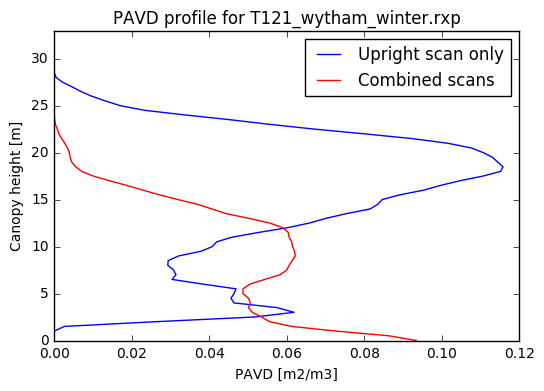

In [42]:
import csv
import numpy as np
import matplotlib.pyplot as plt

path="../example_data/"
in_rxp="T121_wytham_winter.rxp"
# in_rxp="T303_wytham_winter.rxp"
vpf=path+in_rxp.split('.')[0]+".csv"
vpf_comb=path+in_rxp.split('.')[0]+"_comb.csv"

reader=csv.reader(open(vpf), delimiter=",")
firstLine=True
height=PAIe=PAVD=np.array([])
for row in reader:
    if firstLine:
        headers=row
        firstLine=False
    else:
        height=np.append(height,float(row[0]))
        PAIe=np.append(PAIe,float(row[-2]))
        PAVD=np.append(PAVD,float(row[-1]))
        
reader=csv.reader(open(vpf_comb), delimiter=",")
firstLine=True
PAIe_comb=PAVD_comb=np.array([])
for row in reader:
    if firstLine:
        headers=row
        firstLine=False
    else:
        PAIe_comb=np.append(PAIe_comb,float(row[-2]))
        PAVD_comb=np.append(PAVD_comb,float(row[-1]))
        
# print(height)
print("PAIe for upright only is %.2f" % max(PAIe))
print("PAIe for combined scans is %.2f" % max(PAIe_comb))

plt.plot(PAVD,height, label="Upright scan only",color='b')
plt.plot(PAVD_comb,height, label="Combined scans", color='r')
plt.xlabel('PAVD [m2/m3]')
plt.ylabel('Canopy height [m]')
plt.title('PAVD profile for %s' % in_rxp)
plt.ylim(0,33)
plt.legend()
plt.show()
